In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Average
from tensorflow.keras.models import Model
import numpy as np
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
densenet_model = load_model('densenetmodel_100e7.h5')
resnet_model = load_model('resnet50_10.h5')
vgg16_model = load_model('model_second_vgg16.h5')


In [4]:
densenet_model._name = 'densenet_model'
resnet_model._name = 'resnet_model'
vgg16_model._name = 'vgg16_model'

In [5]:
input_shape = densenet_model.input_shape[1:]
input_shape

(256, 256, 3)

In [6]:
ensemble_input = tf.keras.Input(shape=input_shape)

In [7]:
densenet_output = densenet_model(ensemble_input)
resnet_output = resnet_model(ensemble_input)
vgg16_output = vgg16_model(ensemble_input)


In [8]:
averaged_output = Average()([densenet_output, resnet_output, vgg16_output])

In [9]:
ensemble_model = Model(inputs=ensemble_input, outputs=averaged_output, name='ensemble_model1')

In [10]:
ensemble_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Save the ensemble model
ensemble_model.save('ensemble_model1.h5')

print("Ensembled model saved successfully!")

Ensembled model saved successfully!


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
validation_directory = 'PATH TO YOUR VALID DATASET'
validation_datagen = ImageDataGenerator(rescale=1./255)


image_size = (256, 256)

batch_size= 8

datagen = ImageDataGenerator(
    rescale = 1./255)



validation_generator = datagen.flow_from_directory(
    validation_directory,
    target_size=image_size,
    batch_size= 8,
    class_mode='categorical'
)



Found 6994 images belonging to 62 classes.


In [3]:
validation_generator.reset()

In [4]:
predicted_labels = []
true_labels = []

In [2]:
model1 = tf.keras.models.load_model('ensemble_model1.h5')


In [6]:
from PIL import Image
for i in range(validation_generator.samples // validation_generator.batch_size + 1):
    images, labels = validation_generator.next()
    predictions = model1.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    predicted_labels.extend([key for key, value in validation_generator.class_indices.items() if value == class_idx][0] for class_idx in predicted_classes)
    true_labels.extend([key for key, value in validation_generator.class_indices.items() if value == np.argmax(labels[idx])] for idx in range(len(labels)))


1/1 [==============================] - 1s 698ms/step


In [7]:
true_labels = [label[0] for label in true_labels]

In [8]:
true_label= [validation_generator.class_indices[label] for label in true_labels]
predicted_label = [validation_generator.class_indices[label] for label in predicted_labels]

In [9]:
print("Predicted Labels:", predicted_label)
print("True Labels:", true_label)

Predicted Labels: [10, 59, 33, 11, 56, 26, 42, 4, 18, 45, 39, 20, 17, 37, 47, 19, 19, 31, 10, 60, 33, 28, 42, 17, 29, 26, 33, 15, 39, 1, 23, 61, 44, 45, 16, 41, 5, 9, 47, 42, 48, 11, 14, 40, 16, 36, 23, 7, 31, 0, 4, 42, 44, 49, 56, 41, 52, 59, 57, 44, 0, 36, 28, 19, 26, 18, 60, 26, 20, 47, 44, 38, 36, 10, 16, 13, 37, 1, 19, 0, 40, 44, 57, 15, 37, 44, 18, 50, 44, 31, 58, 18, 29, 34, 7, 24, 34, 41, 38, 19, 42, 49, 59, 42, 11, 3, 10, 7, 34, 12, 19, 19, 45, 60, 50, 10, 45, 26, 10, 11, 44, 33, 11, 47, 56, 7, 29, 39, 30, 17, 47, 15, 19, 61, 56, 61, 19, 23, 0, 61, 7, 22, 55, 33, 26, 35, 18, 56, 45, 47, 53, 19, 61, 32, 15, 11, 2, 29, 47, 47, 45, 57, 5, 10, 40, 0, 32, 21, 61, 58, 12, 37, 9, 55, 27, 19, 7, 13, 56, 23, 45, 58, 38, 7, 34, 47, 45, 12, 61, 43, 42, 53, 16, 30, 47, 12, 45, 31, 25, 51, 29, 17, 41, 1, 17, 9, 56, 43, 57, 43, 10, 6, 55, 33, 33, 51, 4, 19, 42, 13, 19, 54, 9, 41, 50, 0, 33, 24, 48, 14, 9, 33, 42, 11, 1, 17, 39, 15, 19, 21, 40, 44, 61, 47, 53, 48, 21, 35, 49, 39, 3, 37, 19, 

In [11]:
from sklearn.metrics import roc_auc_score
import numpy as np

def calculate_auc_scores(true_labels, predicted_probabilities, num_classes):
    auc_scores = []

    for class_index in range(num_classes):
        binary_true_labels = np.where(true_labels == class_index, 1, 0)
        predicted_scores = predicted_probabilities[:, class_index]

        auc = roc_auc_score(binary_true_labels, predicted_scores)
        auc_scores.append(auc)

    average_auc_score = np.mean(auc_scores)

    return auc_scores, average_auc_score

In [12]:
import numpy as np
from sklearn.metrics import roc_auc_score

# Example true labels and predicted labels
true_labels = np.array(true_label)  # Replace with your true labels
predicted_labels = np.array(predicted_label)  # Replace with your predicted labels

# Calculate the AUC score for each class
auc_scores = []
for class_index in range(40):
    # Create binary labels for the current class
    binary_true_labels = np.where(true_labels == class_index, 1, 0)
    binary_predicted_labels = np.where(predicted_labels == class_index, 1, 0)

    # Check if only one instance of the class is present
    if np.sum(binary_true_labels) == 1 or np.sum(binary_predicted_labels) == 1:
        auc = np.nan  # Set AUC score as NaN
    else:
        # Calculate the AUC score for the current class
        auc = roc_auc_score(binary_true_labels, binary_predicted_labels)
    auc_scores.append(auc)

# Calculate the average AUC score
average_auc_score = np.nanmean(auc_scores)

print("AUC Scores for each class:")
print(auc_scores)
print("Average AUC Score:", average_auc_score)

AUC Scores for each class:
[0.9986195873292648, 0.972237743424184, 0.960377358490566, 0.9333109403854348, 0.9459220591275584, 0.927266324163076, 0.973141632415826, 0.9646486678622785, 0.9830818898615509, 0.9887936921835228, 0.9925653424486224, 0.9817810626421336, 0.9847101953787911, 1.0, 0.987878161394804, 0.979823213981823, 0.9471295001512268, 0.9998552821997105, 0.9950799259904692, 0.9590959150054602, 0.9655118892407027, 0.8958350976738935, 0.8569257804424231, 0.9819277108433735, 0.826440286679071, 0.9608221359087411, 0.9730885159949743, 0.9947191818884702, 0.9518744400799393, 0.9324928014905148, 0.9431425494639729, 0.9878348480432422, 0.9411136682130085, 0.9052347149977524, 0.9717165880124563, 0.9663769795287757, 0.9948769786333239, 0.9633373629580224, 0.9801900798473823, 0.9117066393682363]
Average AUC Score: 0.9595121685936144


In [13]:
from sklearn.metrics import f1_score
import numpy as np

# Example true labels and predicted labels
true_labels = np.array(true_label)  # Replace with your true labels
predicted_labels = np.array(predicted_label)  # Replace with your predicted labels

# Calculate the F1 score for each class
f1_scores = []
for class_index in range(40):
    # Create binary labels for the current class
    binary_true_labels = np.where(true_labels == class_index, 1, 0)
    binary_predicted_labels = np.where(predicted_labels == class_index, 1, 0)

    # Calculate the F1 score for the current class
    f1 = f1_score(binary_true_labels, binary_predicted_labels)
    f1_scores.append(f1)

# Calculate the average F1 score
average_f1_score = np.mean(f1_scores)

print("F1 Scores for each class:")
print(f1_scores)
print("Average F1 Score:", average_f1_score)

F1 Scores for each class:
[0.9218106995884774, 0.9502762430939227, 0.8888888888888888, 0.9042553191489362, 0.9036144578313253, 0.84, 0.9680365296803652, 0.9008264462809917, 0.9513513513513514, 0.9726775956284153, 0.9787234042553191, 0.9529411764705882, 0.966542750929368, 1.0, 0.9704142011834319, 0.9264705882352942, 0.926829268292683, 0.9882352941176471, 0.9771689497716894, 0.9143730886850153, 0.8629441624365483, 0.8441558441558441, 0.8163265306122449, 0.9815950920245399, 0.7236842105263158, 0.8413793103448276, 0.914572864321608, 0.9895833333333334, 0.9101796407185628, 0.8930817610062893, 0.8421052631578947, 0.9485294117647058, 0.8374384236453202, 0.88, 0.9251700680272109, 0.9438202247191011, 0.98989898989899, 0.9187279151943463, 0.9765886287625418, 0.8349514563106796]
Average F1 Score: 0.9169542346098651


6994


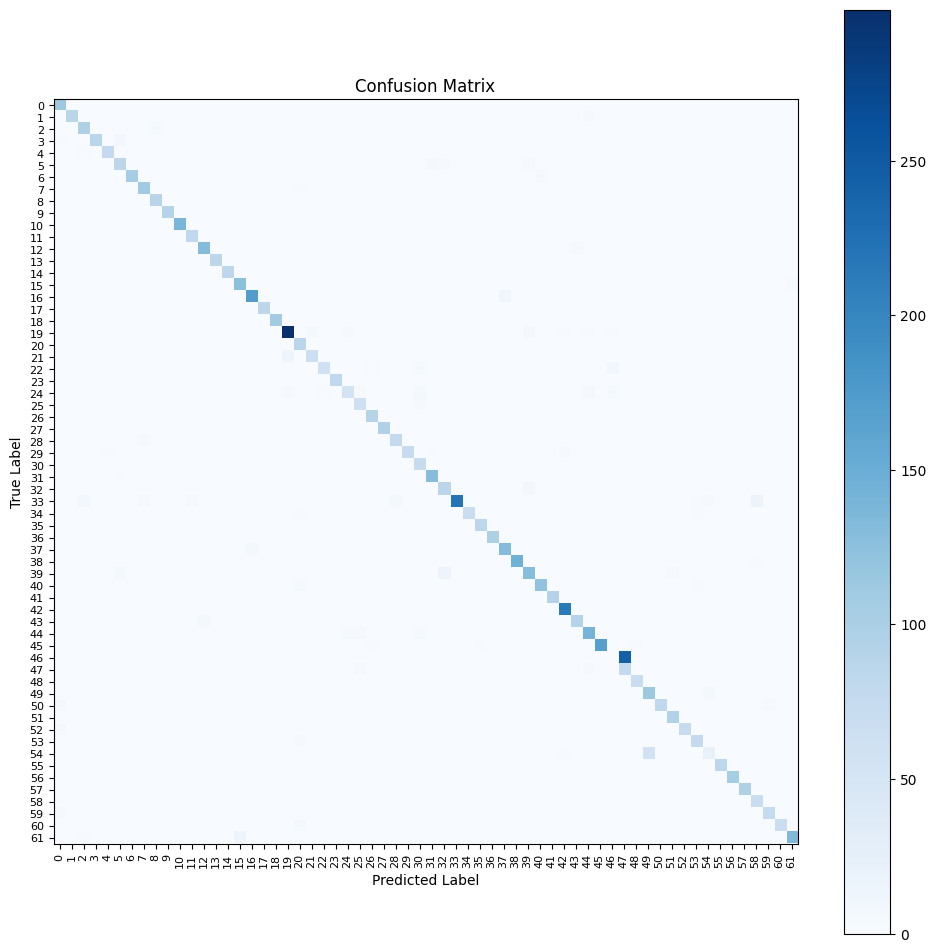

In [17]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
# import torch
import seaborn as sns

print(len(true_labels))

y_true = np.array(true_label)
y_pred = np.array(predicted_label)

y_true, y_pred
# convert numpy arrays to PyTorch tensors
y_true_t = tf.cast(y_true, dtype='float32')
y_pred_t = tf.cast(y_pred, dtype='float32')


# compute confusion matrix
cm = confusion_matrix(y_true_t, y_pred)

# plot confusion matrix
plt.figure(figsize=(12,12))

plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
 
tick_marks = np.arange(len(np.unique(y_true)))
plt.xticks(np.arange(len(np.unique(y_true))), labels=np.unique(y_true), rotation=90)
plt.yticks(np.arange(len(np.unique(y_true))), labels=np.unique(y_true))

plt.tick_params(axis='both', which='major', labelsize=8) 

# plt.grid(visible=True, which='both', axis='y', linestyle='--', color='gray', linewidth=0.5)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

plt.show()

In [3]:
keras_file = 'ensemble_model1.h5'
tf.keras.models.save_model(model1, keras_file)

converter = tf.lite.TFLiteConverter.from_keras_model(model1)
tflite_model = converter.convert()
open('ensemble_model.tflite','wb').write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\acer\AppData\Local\Temp\tmpjvkf0xij\assets


INFO:tensorflow:Assets written to: C:\Users\acer\AppData\Local\Temp\tmpjvkf0xij\assets


320135656